# TP 4 : A la decouverte des signaux sonores

In [1]:
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
import math


In [2]:
def plot_signal(x,y,titre,axe_x,axe_y):
    plt.title(titre)
    plt.plot(x, y)
    plt.xlabel(axe_x)
    plt.ylabel(axe_y)
    plt.show()
    
def plot_signals(x,y,axes_x,axes_y,titres,colors):
    plt.title("Comparaisons des 3 courbes")
    for i in range(len(titres)):
        plt.plot(x[i], y[i] , label=titres[i],color=colors[i],alpha=0.5 if i==0 else 1)
        plt.xlabel(axes_x[i])
        plt.ylabel(axes_y[i])
    plt.legend()
    plt.show()
    
def subplot_signals(x,y,axes_x,axes_y,titres,colors):
    fig,axs=plt.subplots(3,figsize=(7,7))
    
    fig.suptitle("Comparaison des 3 courbes")
    for i in range(len(titres)):
        plt.subplots_adjust(hspace=0.8)
        axs[i].set_xlabel(axes_x[i])
        axs[i].set_ylabel(axes_y[i])
        axs[i].set_title(titres[i])
        axs[i].plot(x[i],y[i],color=colors[i])
   

## 1. Paramétrisations spectrale et cepstrale

In [3]:
fs, signal = wav.read('L1.wav')
signal_origin=signal/2**15
total_length=signal_origin.shape[0]/fs
all_times=np.linspace(0.,total_length , signal.shape[0])
signal=signal[27800:28824]/2**15
N=len(signal)
T=1/fs
print(f'N : {N} echantillons')
print(f'Frequence : {fs/1000} kHz')
print(f'Periode : {T *1000} ms')
length = signal.shape[0] / fs
print(f'Longueur : {length} s')
time = np.linspace(0., length, signal.shape[0])

N : 1024 echantillons
Frequence : 20.0 kHz
Periode : 0.05 ms
Longueur : 0.0512 s


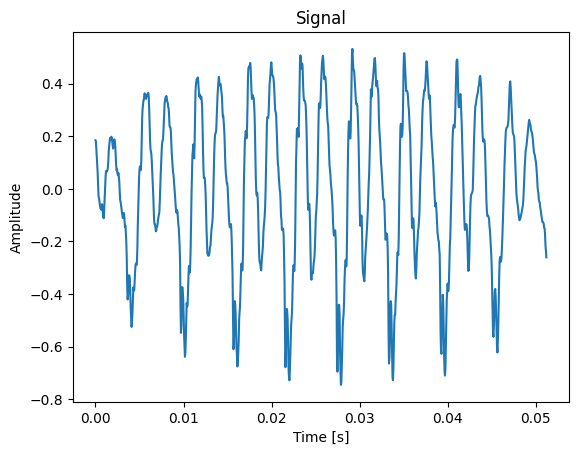

In [4]:
plot_signal(time,signal,"Signal","Time [s]","Amplitude")

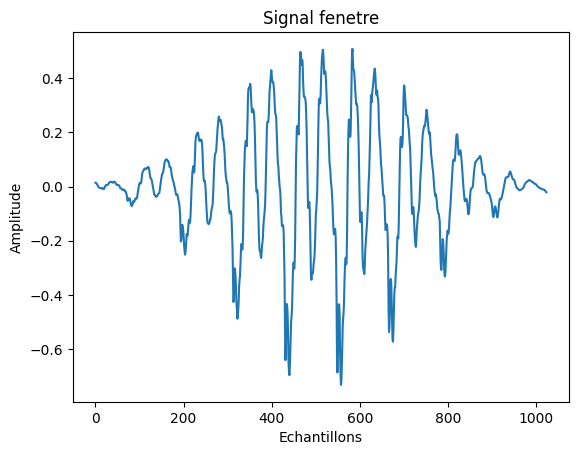

In [16]:
def hamming_window(signal):
    w=np.zeros(signal.shape)
    N=len(signal)
    for n in range(N):
        w[n]=0.54-0.46*math.cos(2*math.pi*n/(N-1))
    return w

def spectre(signal,fs,window=True):
    if window:
        signal_r=signal*hamming_window(signal)
    else:
        signal_r=signal
    fft=np.fft.fft(signal_r)
    fft=np.fft.fftshift(fft)
    spectre=np.abs(fft)
    xf = np.array(np.arange(0, fs, fs/1024)).reshape(1024,)
    #plot_signal(xf,spectre,"Spectre","Freq [Hz]","Amplitude")
    return spectre

def cepstre(signal):
    signal_r=signal*hamming_window(signal)
    fft=np.fft.fft(signal_r)
    F=np.linspace(0,fs//2,signal.shape[0]//2)
    M=1000/math.log(2)*np.log(1+F/1000)
    ifft=np.fft.ifft(np.log(np.abs(fft)))
    return np.abs(ifft)[1:signal.shape[0]//2],M[1:]
plot_signal([i for i in range(N)],signal*hamming_window(signal),"Signal fenetre","Echantillons","Amplitude")

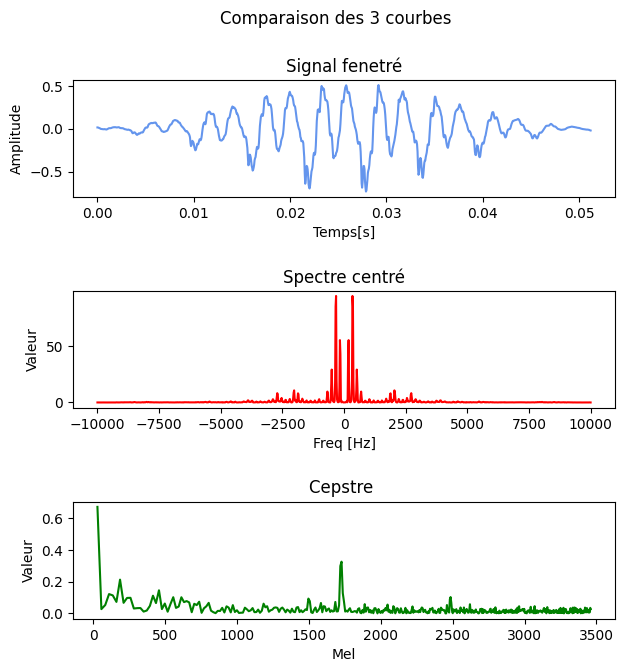

In [17]:
S=spectre(signal,fs,True)
freqs=np.linspace(-fs/2,fs/2,signal.shape[0])
C,qfr=cepstre(signal)
subplot_signals([time,freqs,qfr],[signal*hamming_window(signal),S,C],["Temps[s]","Freq [Hz]","Mel"],["Amplitude","Valeur","Valeur"],["Signal fenetré","Spectre centré","Cepstre "],["cornflowerblue","Red","Green"])




## 2. Extraction de paramètres temporels

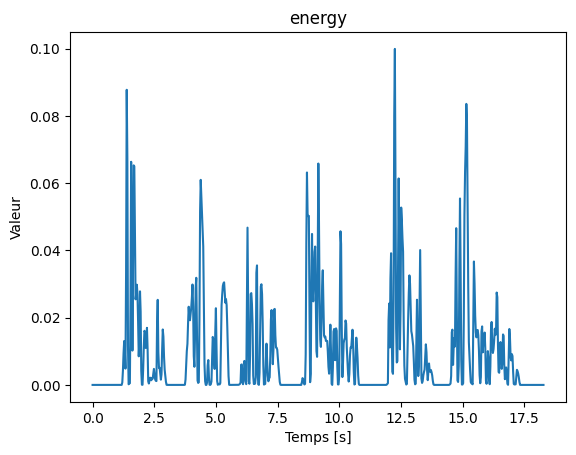

In [7]:
def energy(sig,window):
    hop=window//2
    nb_window=len(sig)//hop
    res=np.zeros(nb_window)
    for w in range(nb_window):
        i=hop*w
        res[w]=np.sum(sig[i:i+window]**2)/window
        
    return res
    
def ZCR(sig,window):
    hop=window//2
    nb_window=len(sig)//hop
    res=np.zeros(nb_window)
    for w in range(nb_window-1):
        i=hop*w
        s1= np.sign(sig[i+1:i+window])
        s2= np.sign(sig[i:i+window-1])
        res[w]=np.sum(np.abs(s1-s2))/(2*window-2)
        #res[w]=len(np.nonzero(np.diff(sig[i:i+window] < 0))[0])/window
    return res


energy(signal_origin,1024)

E= energy(signal_origin,1024)
times2= np.linspace(0., total_length, len(E))
plot_signal(times2,E,"energy","Temps [s]","Valeur")

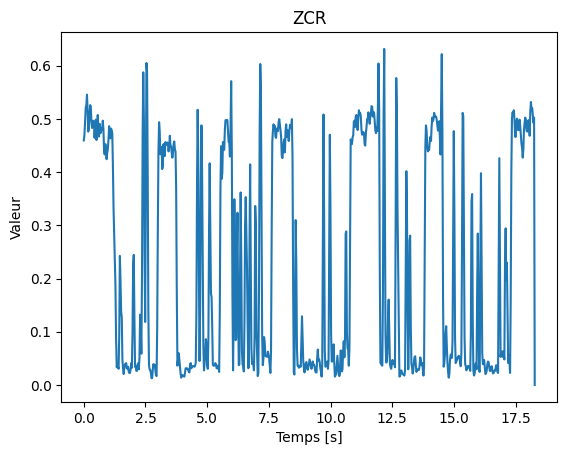

In [8]:
Z=ZCR(signal_origin,1024)
plot_signal(times2,Z,"ZCR","Temps [s]","Valeur")

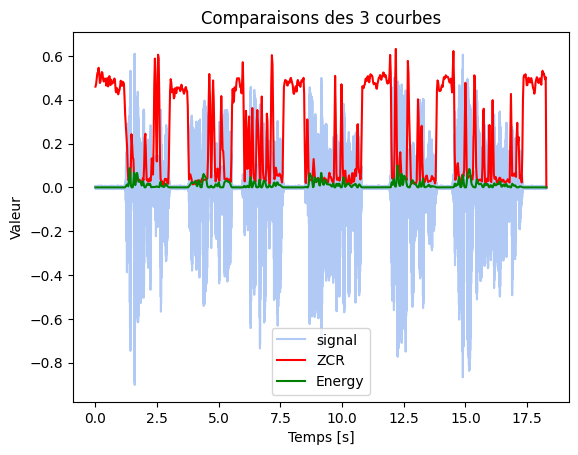

In [9]:
plot_signals([all_times,times2,times2],[signal_origin,Z,E],["Temps [s]","Temps [s]","Temps [s]"],["Amplitude","Valeur","Valeur"],["signal","ZCR","Energy"],["cornflowerblue","Red","Green"])

Pour ce signal le ZCR semble permettre de repérer les silences et l'energie la parole.

## 3. Spectrogramme

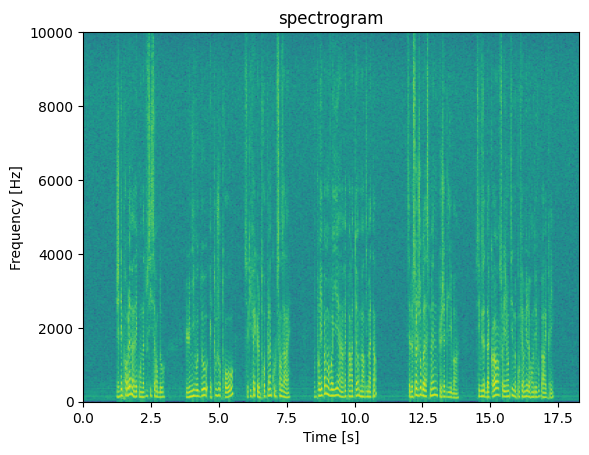

In [10]:
def spectro(sig,size_window=1024):
    fft_size = size_window
    num_rows = int(np.floor(len(sig)/fft_size))
    spectrogram = np.zeros((num_rows, fft_size))
    for i in range(num_rows):
        spectrogram[i,:] = np.log(np.abs(np.fft.fft(sig[i*fft_size:(i+1)*fft_size]*hamming_window(signal))))
    spectrogram=spectrogram.T[:N//2,:]
    plt.imshow(spectrogram, aspect='auto', extent = [0, signal_origin.shape[0] / fs, 0, fs/2],origin="lower")
    plt.title("spectrogram")
    plt.ylabel("Frequency [Hz]")
    plt.xlabel("Time [s]")
    plt.show()
    return spectrogram
spectrogram=spectro(signal_origin)


### Matplotlib spectro

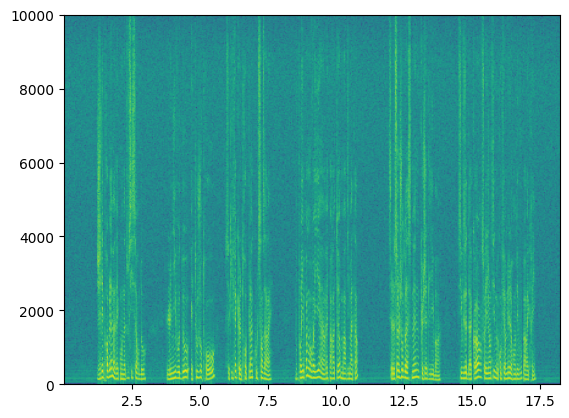

In [11]:
plt.specgram(signal_origin, Fs=fs,window=np.hamming(1024), NFFT=1024)
print()